In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [2]:
import keyboard

In [3]:
from functions import *

In [4]:
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 20000

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.25

QINIT = np.array([-2, -2, -2])

In [5]:
def recommender(Q, initial_guess, maximize=False):
    if not maximize:
        fun = lambda x: total_welfare(Q, x)
    else:
        fun = lambda x: -1 * total_welfare(Q, x)

    recommendation = minimize(fun, x0=initial_guess, bounds=[(0, 2) for i in range(len(initial_guess))],
                              method=None)
    S = np.rint(recommendation.x).astype(int)
    return S

In [6]:
def recommender_next_state(R, Q, S, A, recommender_on):
    if recommender_on:
        S = recommender(Q, initial_guess=A)
    else:
        S = S
#     print(recommender_on, S)
    return S

In [7]:
Q = InitializeQTable(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}

S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

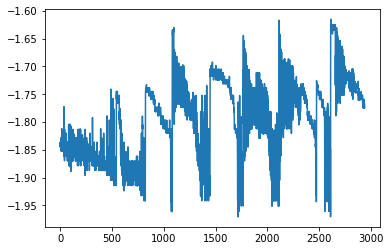

In [ ]:
# %matplotlib widget

fig = plt.figure()
hfig = display(fig, display_id=True)
recommender_on = False

on_timesteps = []
off_timesteps = []

for t in range(N_ITER):
    if keyboard.is_pressed("r"):
        recommender_on = True
        on_timesteps.append(t)
    elif keyboard.is_pressed("e"):
        recommender_on = False
        off_timesteps.append(t)
    else:
        off_timesteps.append(t)
    
    
    S = recommender_next_state(R, Q, S, A, recommender_on)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R = braess_augmented_network(A)

    Q = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            # "groups": count_groups(Q[ind, S, :], 0.1),
            # "Qvar": Q[ind, S, :].var(axis=0)
           }
    
    plt.clf()
    plt.plot(np.arange(0, t, 1), [M[i]["R"].mean() for i in range(t)])
#     plt.plot(on_timesteps, [M[i]["R"].mean() for i in on_timesteps])
#     plt.plot(off_timesteps, [M[i]["R"].mean() for i in off_timesteps])
#     ax2.hist(np.bincount(S))
    fig.canvas.draw()
    hfig.update(fig)
    time.sleep(0.1)
    

In [ ]:
def animate(step):
    